In [1]:
%matplotlib notebook
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

<IPython.core.display.Javascript object>


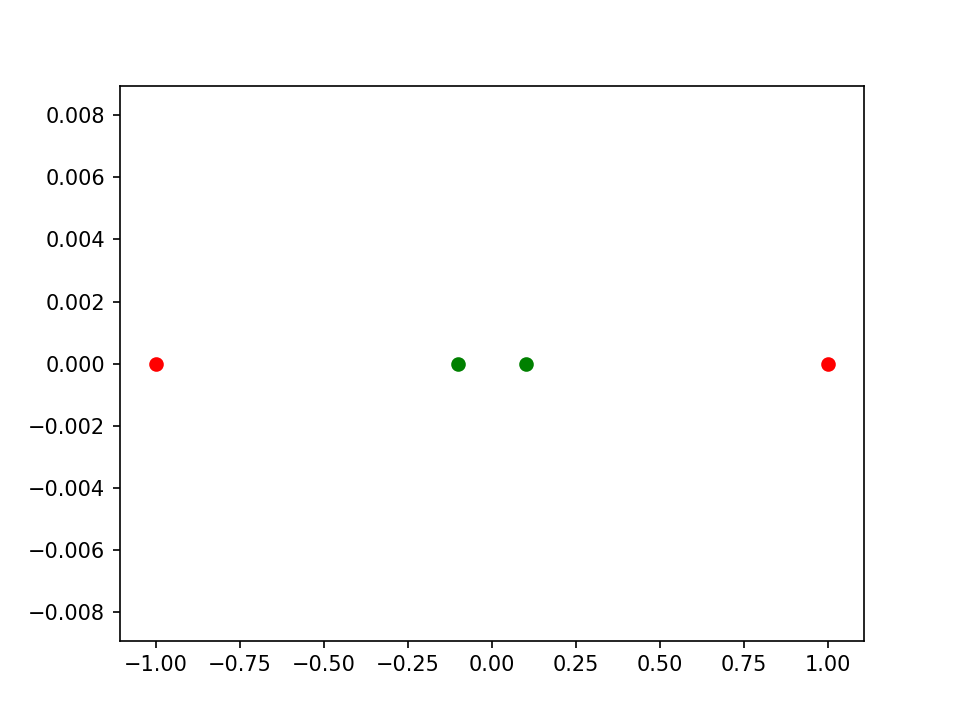

In [2]:
random.seed(3)

def rand_cluster(n,c,r):
    """returns n random points in disk of radius r centered at c"""
    x = c
    points = []
    for i in range(n):
        theta = 2*math.pi*random.random()
        s = r*random.random()
        points.append([x+s*math.cos(theta)])
    return points

def rand_clusters(k,n,r, a,b,c,d):
    """return k clusters of n points each in random disks of radius r
    where the centers of the disk are chosen randomly in [a,b]x[c,d]"""
    clusters = []
    for _ in range(k):
        x = a + (b-a)*random.random()
        y = c + (d-c)*random.random()
        clusters.extend(rand_cluster(n,x,r))
    return clusters

n = 2
X = rand_clusters(2,n,0.8,-1,1,-1,1)
data = np.array(X)
label = np.transpose(np.array([[1]*n + [0]*n]))

# label = np.array([1]*n + [0]*n)
data = []
label = []
data.append([-1])
data.append([1])
data.append([0.1])
data.append([-0.1])
label.append([1])
label.append([1])
label.append([0])
label.append([0])
data = np.array(data)
label = np.array(label)
# print (data, label)

plt.scatter(data[:n], [0]*n, color=['red'])
plt.scatter(data[n:], [0]*n, color=['green'])
plt.show()

In [10]:
# tf.reset_default_graph()

# def weight_variable(shape, name):
#     initial = tf.truncated_normal(shape=shape, stddev=0.1)
#     return tf.get_variable(name=name, initializer=initial)

# def bias_variable(shape, name):
#     initial = tf.constant(0.1, shape=shape)
#     return tf.get_variable(name=name, initializer=initial)


x = tf.placeholder(tf.float32, [None, 1])
y_ = tf.placeholder(tf.float32, [None, 1])


n_input = 1
n_hidden = 2
n_output = 1
lmd = 0


rang = 1.
parameters = tf.Variable(tf.concat([#tf.truncated_normal([n_input * n_hidden]), 
                                    tf.random_uniform([5], minval= -rang, maxval= rang),
                                   ], 0))

# weights1 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_input*n_hidden]), [n_input, n_hidden])

weights1 = tf.constant([1.0, -1.0], shape=[1, 2])
idx_from = 0 
biases1 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_hidden]), [n_hidden])
hidden = tf.nn.relu(tf.matmul(x, weights1) + biases1)

idx_from = idx_from + n_hidden
weights2 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_hidden*n_output]), [n_hidden, n_output])
idx_from = idx_from + n_hidden*n_output
biases2 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_output]), [n_output])
y = tf.nn.relu(tf.matmul(hidden, weights2) + biases2)

loss = tf.reduce_mean(tf.reduce_sum(tf.pow(y_ - y, 2), reduction_indices=[1])) #I also tried simply tf.nn.l2_loss(y_ - y)

lr = tf.placeholder(tf.float32, shape=[])
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
grads_and_vars = optimizer.compute_gradients(loss)
grad = tf.gradients(loss, parameters)
hess = tf.hessians(loss, parameters)
train_step = optimizer.apply_gradients(grads_and_vars)

In [11]:
def get_accuracy():
    pred = sess.run(y, feed_dict={x: data, y_: label})    
    match = [(pred[i] - 0.5) * (label[i] - 0.5) > 0  for i in range(n*2)]
    acc = sum(match)*1./2/n
    return acc[0]

def get_norm_grad():
    nng = 0.
    for gv in grad:
#         print(str(sess.run(gv[0], feed_dict={x: data, y_: label})) + " - " + gv[1].name)
        g = sess.run(gv, feed_dict={x: data, y_: label})
#         print (g)
        nng += np.linalg.norm(g) ** 2
    return np.sqrt(nng)
    
     
def displayH(a):
    a = np.array(a[0])
#     print ("Matrix["+("%d" %a.shape[0])+"]["+("%d" %a.shape[1])+"]")
    rows = a.shape[0]
    cols = a.shape[1]
    for i in range(0, rows):
        for j in range(0, cols):
            print("%0.2g " %a[i,j], end="")
        print ()
    print ()

In [12]:
sess = tf.InteractiveSession()
l = 2e-1
dic = {}
nr = 100
ni = 20

cmap = cm.brg  # nipy_spectral, Set1, Paired, brg
colors = cm.jet(np.linspace(0.8, 0.3, ni+1))
colors[:, 1] = np.linspace(0.5, 0.5, ni+1)
colors[:, 2] = np.linspace(0., 0.0, ni+1)

for r in range(nr):
    
    dic[r] = {}
    dic[r]['w1'] = np.zeros(ni+1)
    dic[r]['w2'] = np.zeros(ni+1) 
    dic[r]['b1'] = np.zeros(ni+1)
    dic[r]['b2'] = np.zeros(ni+1) 
    dic[r]['b3'] = np.zeros(ni+1)     
    dic[r]['s'] = np.zeros(ni+1)
    
    tf.global_variables_initializer().run()
    v, w = sess.run([loss, parameters], feed_dict={x: data, y_: label})    
    nng = get_norm_grad()
    dic[r]['w1'][0] = w[2]
    dic[r]['w2'][0] = w[3]
    dic[r]['b1'][0] = w[0]
    dic[r]['b2'][0] = w[1]
    dic[r]['b3'][0] = w[4]
    dic[r]['s'][0] = max(v,1e-5)
 
    for i in range(1,ni+1):
        sess.run(train_step, feed_dict={x: data, y_: label, lr: l})
        v, w = sess.run([loss, parameters], feed_dict={x: data, y_: label})    
        nng = get_norm_grad()
        dic[r]['w1'][i] = w[2]
        dic[r]['w2'][i] = w[3]
        dic[r]['b1'][i] = w[0]
        dic[r]['b2'][i] = w[1]
        dic[r]['b3'][i] = w[4]
        dic[r]['s'][i] = max(v,1e-5)

    v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label})    
    nng = get_norm_grad()
    eigs = sorted(np.linalg.eigvals(H)[0])
    print("Epoch {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g}, nnw {:.4g}, high_eig {:.4g}, low_eig {:.4g}."\
            .format(i+1, get_accuracy()*100, v, nng, np.linalg.norm(w[:]), max(eigs), min(eigs) ))


sess.close() 

Epoch 51, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.017, high_eig 0, low_eig 0.
Epoch 51, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.612, high_eig 0, low_eig 0.
Epoch 51, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.666, high_eig 0, low_eig 0.
Epoch 51, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.596, high_eig 0, low_eig 0.
Epoch 51, accuracy 75.00%, loss 0.250007, nng 0.002537, nnw 1.966, high_eig 1.845, low_eig -0.002289.
Epoch 51, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.098, high_eig 0, low_eig 0.
Epoch 51, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.232, high_eig 0, low_eig 0.
Epoch 51, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.469, high_eig 0, low_eig 0.
Epoch 51, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.432, high_eig 0, low_eig 0.
Epoch 51, accuracy 75.00%, loss 0.250001, nng 0.0009032, nnw 1.221, high_eig 1.547, low_eig -0.0005164.
Epoch 51, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.401, high_eig 0, low_eig 0.
Epoch 51, accuracy 75.00%, loss 0.250040, nng 0

Epoch 51, accuracy 100.00%, loss 0.095649, nng 0.1699, nnw 1.014, high_eig 2.255, low_eig -0.05112.
Epoch 51, accuracy 75.00%, loss 0.250003, nng 0.001709, nnw 1.599, high_eig 1.522, low_eig -0.0008125.
Epoch 51, accuracy 100.00%, loss 0.002280, nng 0.03709, nnw 1.434, high_eig 2.944, low_eig 0.01728.
Epoch 51, accuracy 75.00%, loss 0.250000, nng 1.136e-07, nnw 1.398, high_eig 1.816, low_eig -2.676e-08.
Epoch 51, accuracy 75.00%, loss 0.250000, nng 0.0006701, nnw 1.339, high_eig 1.581, low_eig -0.0002903.
Epoch 51, accuracy 75.00%, loss 0.251788, nng 0.02645, nnw 1.967, high_eig 2.191, low_eig -0.0003138.
Epoch 51, accuracy 100.00%, loss 0.000359, nng 0.01154, nnw 1.514, high_eig 3.427, low_eig -6.45e-06.
Epoch 51, accuracy 75.00%, loss 0.250408, nng 0.01188, nnw 1.265, high_eig 2.454, low_eig -2.509e-05.
Epoch 51, accuracy 100.00%, loss 0.000427, nng 0.01392, nnw 1.593, high_eig 3.04, low_eig 0.003455.
Epoch 51, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.068, high_eig 0, low_eig 0.


<IPython.core.display.Javascript object>


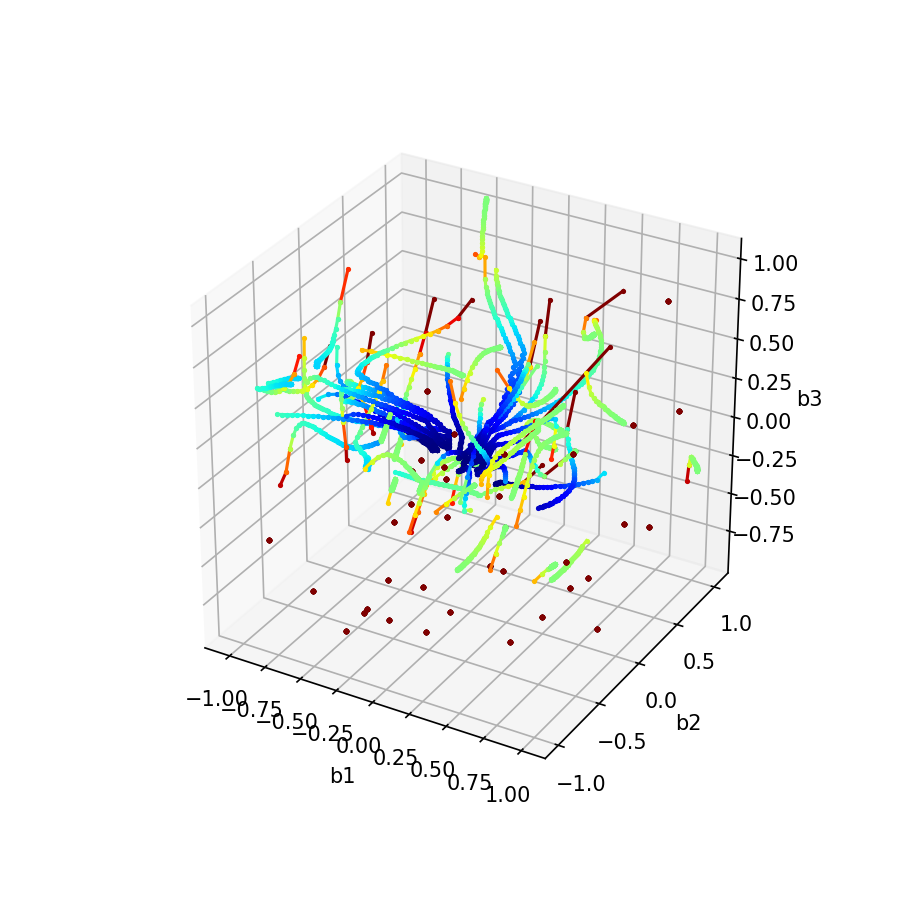

In [13]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
cmap = plt.get_cmap('jet')

for r in range(nr):
#     print ([cm(dic[r]['s'][i]/10) for i in range(ni-1)])
    ax.set_prop_cycle('color', [cmap(dic[r]['s'][i]*2) for i in range(ni-1)])
    for i in range(ni-1):
        pp = ax.plot(dic[r]['b1'][i:i+2], dic[r]['b2'][i:i+2], dic[r]['b3'][i:i+2]
                , marker='o', markersize=1.5)

ax.set_xlabel('b1')
ax.set_ylabel('b2')
ax.set_zlabel('b3')
plt.show()

<IPython.core.display.Javascript object>


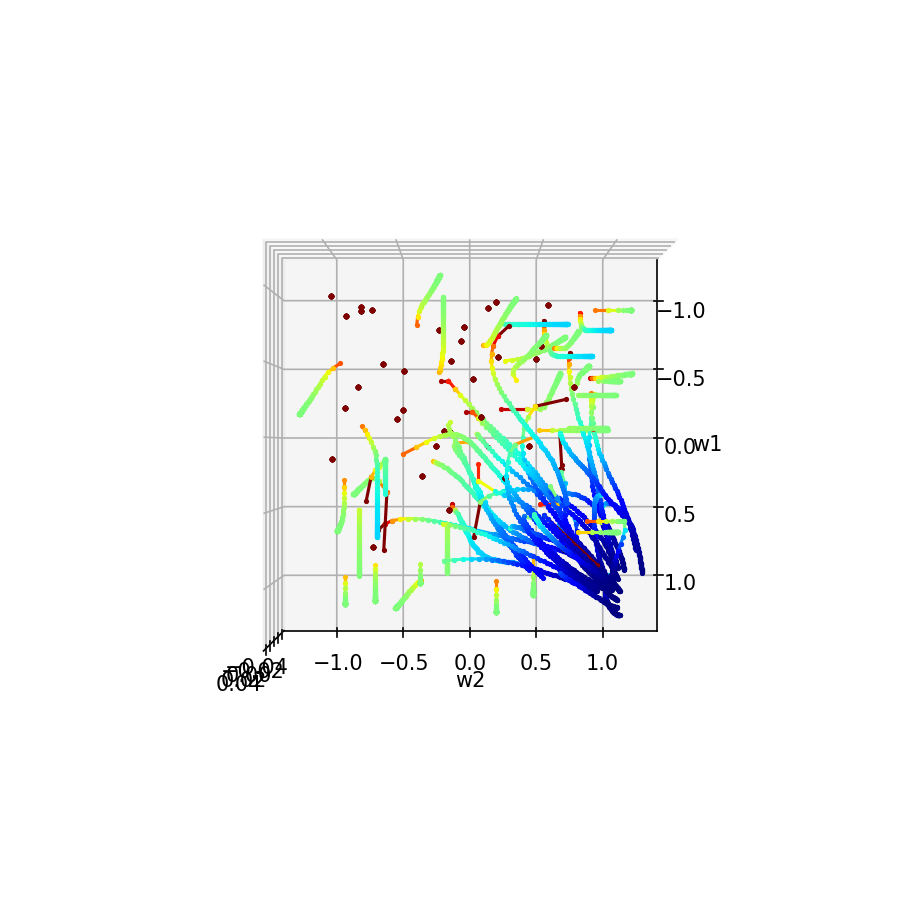

In [14]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
cmap = plt.get_cmap('jet')

for r in range(nr):
#     print ([cm(dic[r]['s'][i]/10) for i in range(ni-1)])
    ax.set_prop_cycle('color', [cmap(dic[r]['s'][i]*2) for i in range(ni-1)])
    for i in range(ni-1):
        ax.plot(dic[r]['w1'][i:i+2], dic[r]['w2'][i:i+2]
                , marker='o', markersize=1.5)

ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.view_init(elev=90., azim=0)
plt.show()

In [115]:
sess = tf.InteractiveSession()
l = 3e-1
dic = {}
nr = 1000

cmap = cm.brg  # nipy_spectral, Set1, Paired, brg
colors = cm.jet(np.linspace(0.8, 0.3, ni+1))
colors[:, 1] = np.linspace(0.5, 0.5, ni+1)
colors[:, 2] = np.linspace(0., 0.0, ni+1)

for r in range(nr):
    
    dic[r] = {}
    tf.global_variables_initializer().run()
    v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label})    
#     nng = get_norm_grad()
    dic[r]['w1'] = w[2]
    dic[r]['w2'] = w[3]
    dic[r]['b1'] = w[0]
    dic[r]['b2'] = w[1]
    dic[r]['b3'] = w[4]
    dic[r]['s'] = max(v,1e-5)
#     eigs = sorted(np.linalg.eigvals(H)[0])
#     print("Epoch {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g}, nnw {:.4g}, high_eig {:.4g}, low_eig {:.4g}."\
#             .format(i+1, get_accuracy()*100, v, nng, np.linalg.norm(w[:]), max(eigs), min(eigs) ))

sess.close() 

<IPython.core.display.Javascript object>


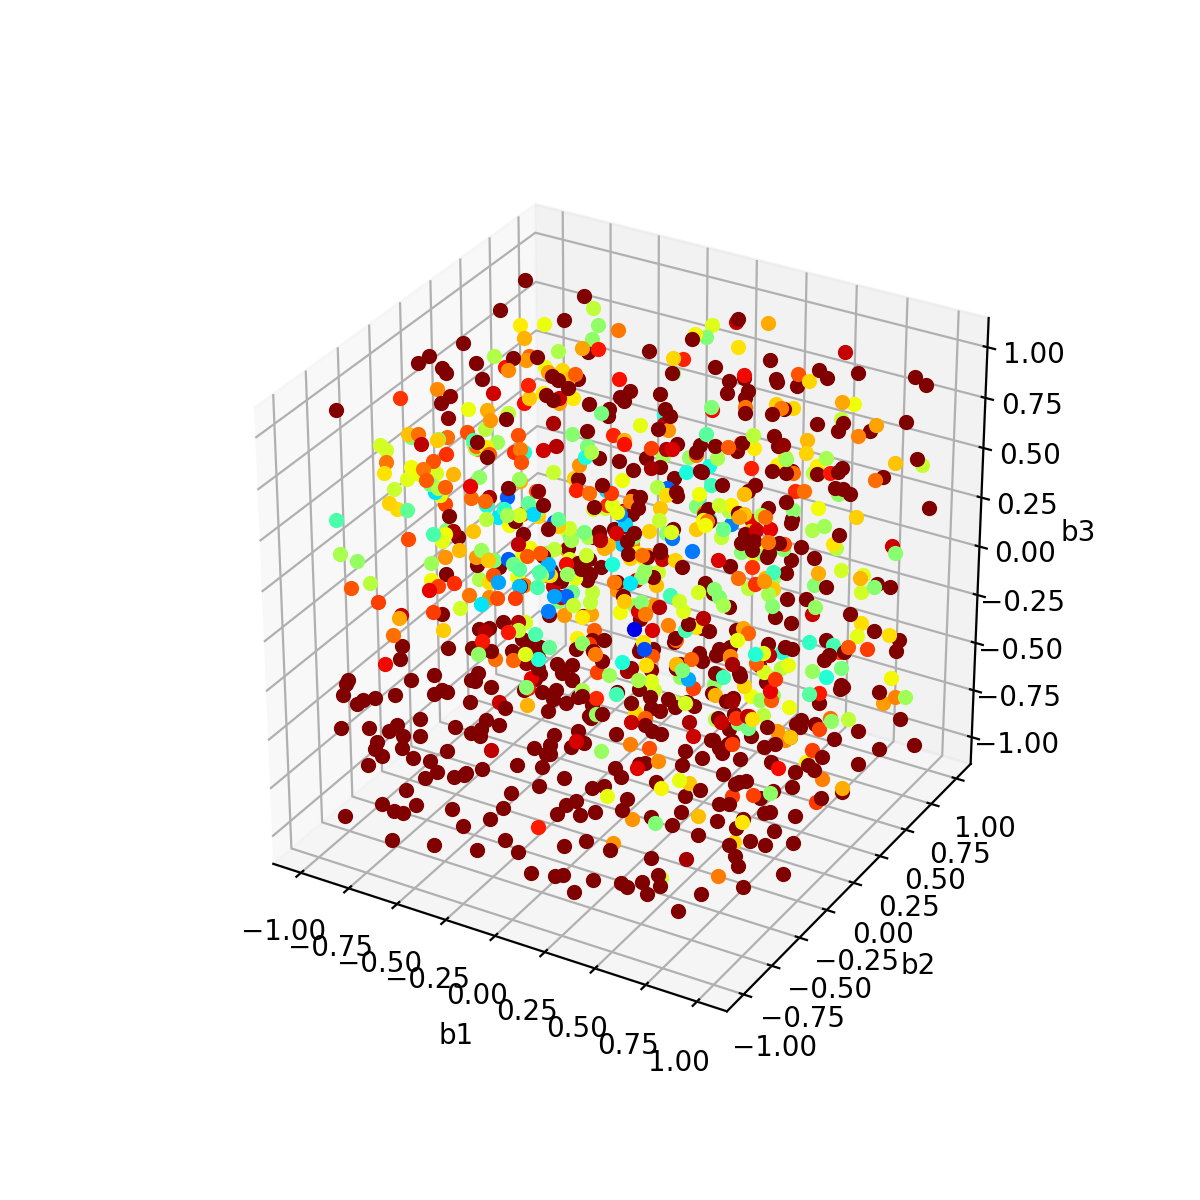

In [116]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
cmap = plt.get_cmap('jet')

for r in range(nr):
#     print ([cm(dic[r]['s'][i]/10) for i in range(ni-1)])
    ax.set_prop_cycle('color', [cmap(dic[r]['s']*2)])
    pp = ax.scatter(dic[r]['b1'], dic[r]['b2'], dic[r]['b3'])

ax.set_xlabel('b1')
ax.set_ylabel('b2')
ax.set_zlabel('b3')
plt.show()

<IPython.core.display.Javascript object>


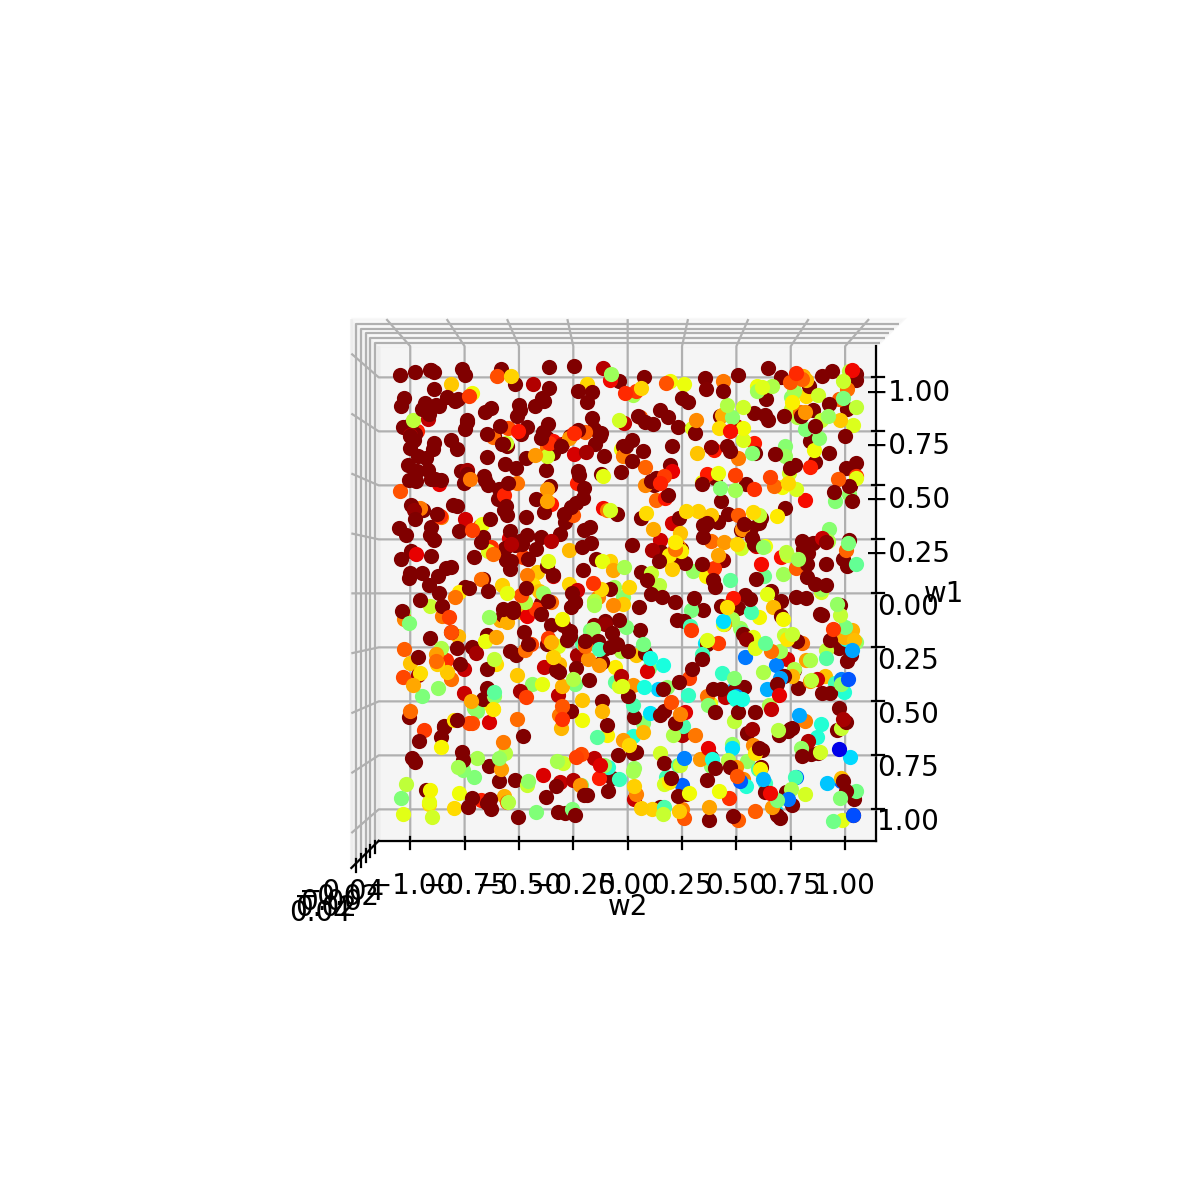

In [117]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
cmap = plt.get_cmap('jet')

for r in range(nr):
#     print ([cm(dic[r]['s'][i]/10) for i in range(ni-1)])
    ax.set_prop_cycle('color', [cmap(dic[r]['s']*2)])
    ax.scatter(dic[r]['w1'], dic[r]['w2'])

ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.view_init(elev=90., azim=0)
plt.show()

<IPython.core.display.Javascript object>


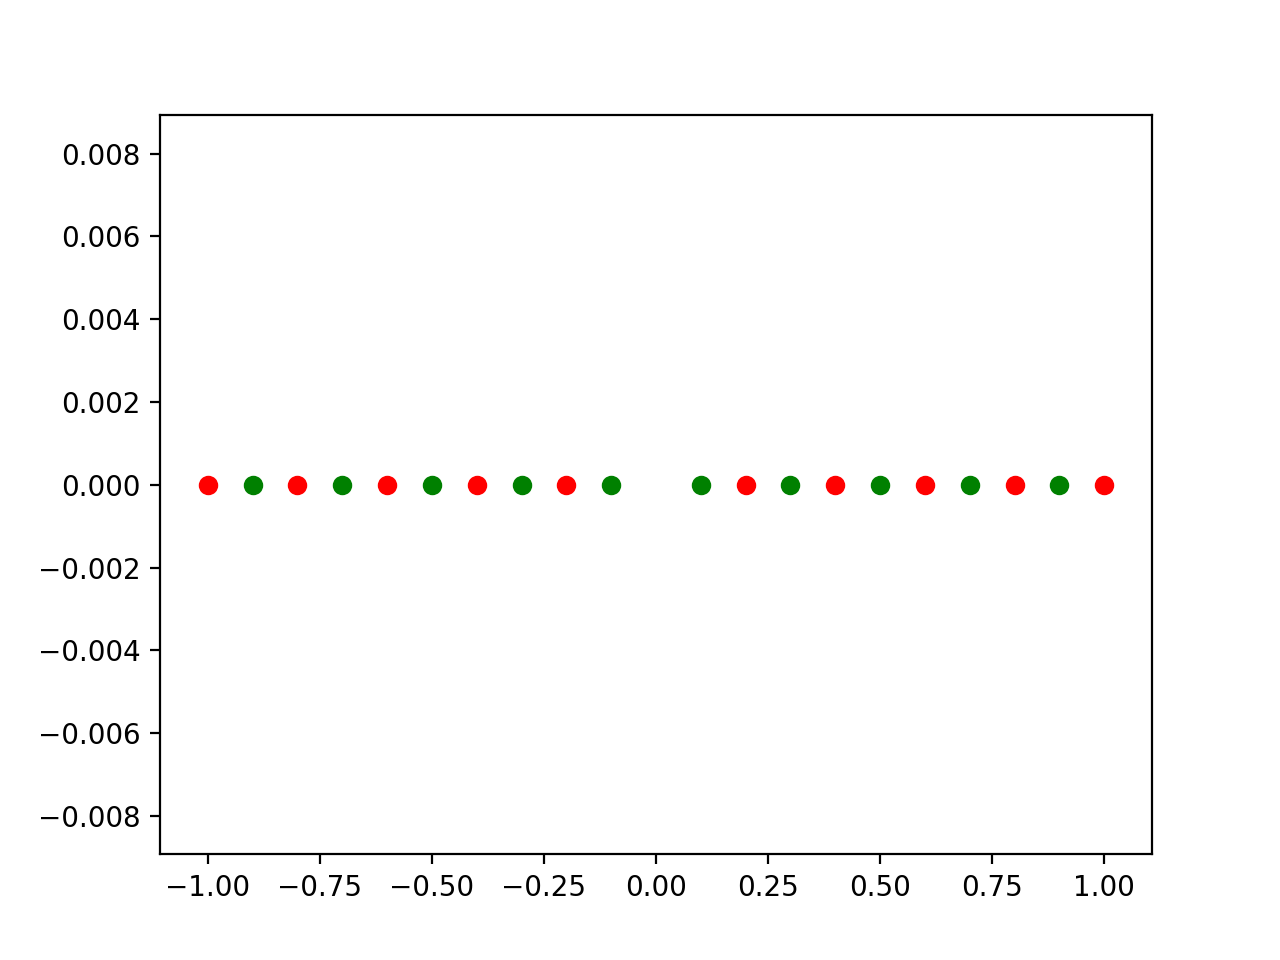

In [3]:
n = 10
data = []
label = []
data.append([-1])
data.append([-.8])
data.append([-0.6])
data.append([-0.4])
data.append([-0.2])
data.append([0.2])
data.append([0.4])
data.append([0.6])
data.append([0.8])
data.append([1.0])

data.append([-0.9])
data.append([-0.7])
data.append([-0.5])
data.append([-0.3])
data.append([-0.1])
data.append([0.1])
data.append([0.3])
data.append([0.5])
data.append([0.7])
data.append([0.9])

label.append([1])
label.append([1])
label.append([1])
label.append([1])
label.append([1])
label.append([1])
label.append([1])
label.append([1])
label.append([1])
label.append([1])

label.append([0])
label.append([0])
label.append([0])
label.append([0])
label.append([0])
label.append([0])
label.append([0])
label.append([0])
label.append([0])
label.append([0])
data = np.array(data)
label = np.array(label)
# print (data, label)

fig = plt.figure()
plt.scatter(data[:n], [0]*n, color=['red'])
plt.scatter(data[n:], [0]*n, color=['green'])
plt.show()

In [7]:
sess = tf.InteractiveSession()
l = 3e-1
dic = {}
nr = 100
ni = 20

cmap = cm.brg  # nipy_spectral, Set1, Paired, brg
colors = cm.jet(np.linspace(0.8, 0.3, ni+1))
colors[:, 1] = np.linspace(0.5, 0.5, ni+1)
colors[:, 2] = np.linspace(0., 0.0, ni+1)

for r in range(nr):
    
    dic[r] = {}
    dic[r]['w1'] = np.zeros(ni+1)
    dic[r]['w2'] = np.zeros(ni+1) 
    dic[r]['b1'] = np.zeros(ni+1)
    dic[r]['b2'] = np.zeros(ni+1) 
    dic[r]['b3'] = np.zeros(ni+1)     
    dic[r]['s'] = np.zeros(ni+1)
    
    tf.global_variables_initializer().run()
    v, w = sess.run([loss, parameters], feed_dict={x: data, y_: label})    
    nng = get_norm_grad()
    dic[r]['w1'][0] = w[2]
    dic[r]['w2'][0] = w[3]
    dic[r]['b1'][0] = w[0]
    dic[r]['b2'][0] = w[1]
    dic[r]['b3'][0] = w[4]
    dic[r]['s'][0] = max(v,1e-5)
 
    for i in range(1,ni+1):
        sess.run(train_step, feed_dict={x: data, y_: label, lr: l})
        v, w = sess.run([loss, parameters], feed_dict={x: data, y_: label})    
        nng = get_norm_grad()
        dic[r]['w1'][i] = w[2]
        dic[r]['w2'][i] = w[3]
        dic[r]['b1'][i] = w[0]
        dic[r]['b2'][i] = w[1]
        dic[r]['b3'][i] = w[4]
        dic[r]['s'][i] = max(v,1e-5)

    v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label})    
    nng = get_norm_grad()
    eigs = sorted(np.linalg.eigvals(H)[0])
    print("Epoch {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g}, nnw {:.4g}, high_eig {:.4g}, low_eig {:.4g}."\
            .format(i+1, get_accuracy()*100, v, nng, np.linalg.norm(w[:]), max(eigs), min(eigs) ))


sess.close() 

Epoch 21, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.318, high_eig 0, low_eig 0.
Epoch 21, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.275, high_eig 0, low_eig 0.
Epoch 21, accuracy 55.00%, loss 0.383449, nng 0.03195, nnw 1.43, high_eig 3.376, low_eig -0.001618.
Epoch 21, accuracy 60.00%, loss 0.245459, nng 0.01826, nnw 0.5785, high_eig 2.196, low_eig -0.001396.
Epoch 21, accuracy 60.00%, loss 0.242693, nng 0.01864, nnw 0.9924, high_eig 3.823, low_eig -3.225e-05.
Epoch 21, accuracy 55.00%, loss 0.372436, nng 0.01415, nnw 1.037, high_eig 2.38, low_eig -0.002514.
Epoch 21, accuracy 55.00%, loss 0.251269, nng 0.02958, nnw 1.01, high_eig 2.556, low_eig -0.006221.
Epoch 21, accuracy 45.00%, loss 0.251546, nng 0.01231, nnw 1.151, high_eig 2.684, low_eig -0.0009499.
Epoch 21, accuracy 40.00%, loss 0.252926, nng 0.02966, nnw 0.7269, high_eig 2.702, low_eig -0.001245.
Epoch 21, accuracy 45.00%, loss 0.252637, nng 0.03675, nnw 1.024, high_eig 3.077, low_eig -0.02564.
Epoch 21, accuracy 60.00%

Epoch 21, accuracy 60.00%, loss 0.243129, nng 0.01252, nnw 1.029, high_eig 4.129, low_eig -0.01083.
Epoch 21, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.338, high_eig 0, low_eig 0.
Epoch 21, accuracy 50.00%, loss 0.248508, nng 0.03417, nnw 0.5296, high_eig 2.371, low_eig -0.009391.
Epoch 21, accuracy 50.00%, loss 0.252351, nng 0.01507, nnw 1.218, high_eig 2.055, low_eig -0.01047.
Epoch 21, accuracy 60.00%, loss 0.250299, nng 0.03419, nnw 0.8773, high_eig 2.797, low_eig 0.01142.
Epoch 21, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.159, high_eig 0, low_eig 0.
Epoch 21, accuracy 55.00%, loss 0.245982, nng 0.02492, nnw 1.35, high_eig 3.844, low_eig -0.0003658.
Epoch 21, accuracy 55.00%, loss 0.248818, nng 0.009004, nnw 1.133, high_eig 2.023, low_eig -0.01744.
Epoch 21, accuracy 55.00%, loss 0.245159, nng 0.01712, nnw 0.977, high_eig 3.364, low_eig 0.003951.
Epoch 21, accuracy 55.00%, loss 0.254037, nng 0.04179, nnw 1.045, high_eig 2.457, low_eig 0.01628.
Epoch 21, accuracy 45.00%, loss

<IPython.core.display.Javascript object>


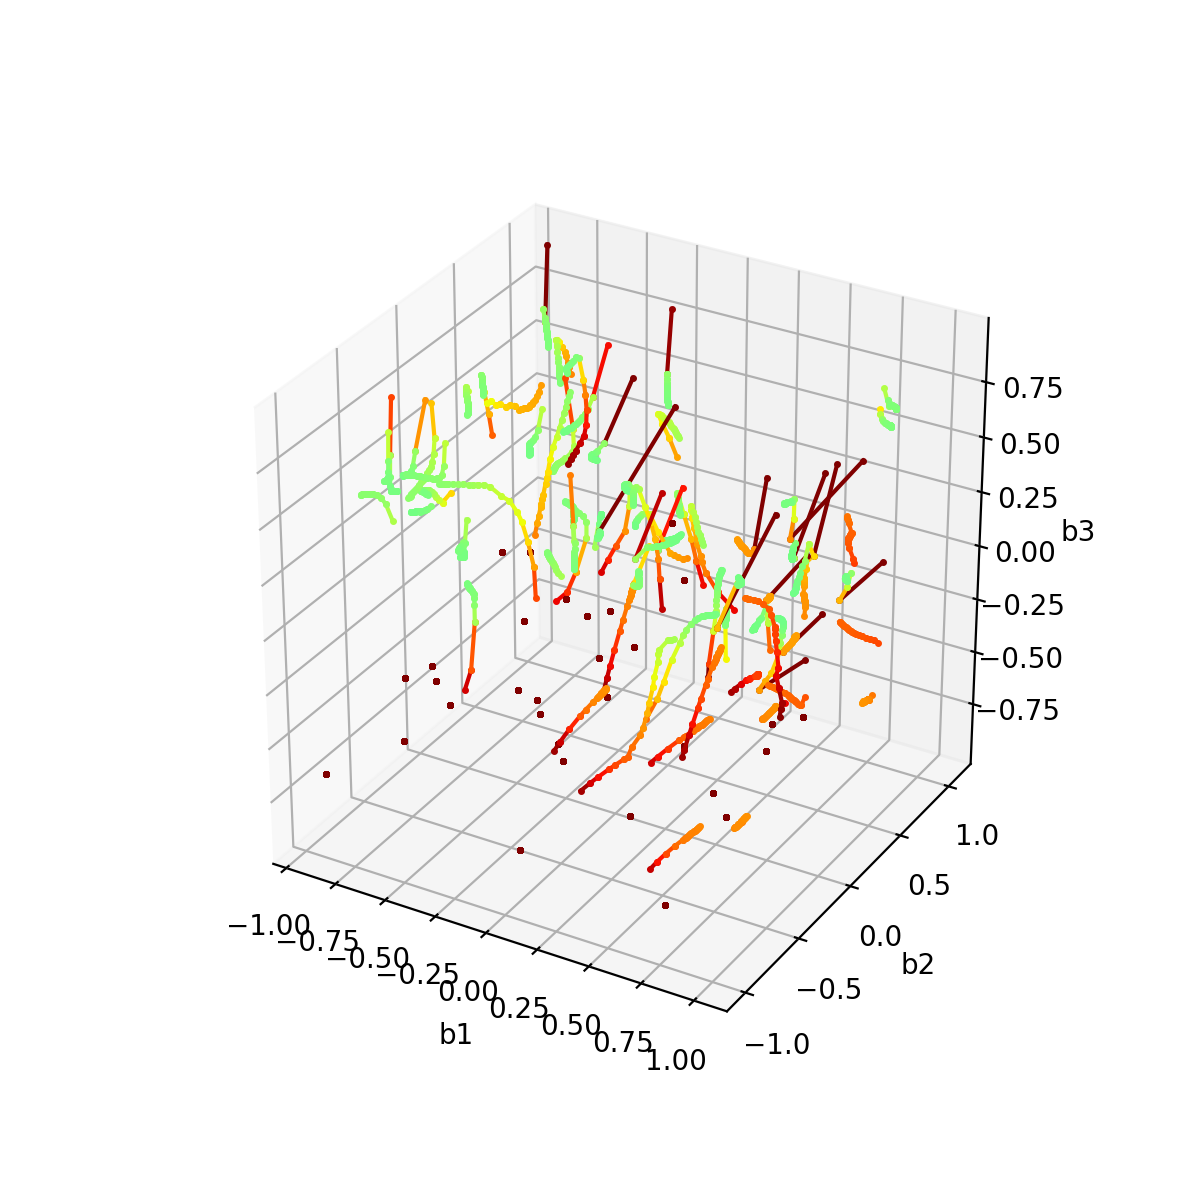

In [8]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
cmap = plt.get_cmap('jet')

for r in range(nr):
#     print ([cm(dic[r]['s'][i]/10) for i in range(ni-1)])
    ax.set_prop_cycle('color', [cmap(dic[r]['s'][i]*2) for i in range(ni-1)])
    for i in range(ni-1):
        pp = ax.plot(dic[r]['b1'][i:i+2], dic[r]['b2'][i:i+2], dic[r]['b3'][i:i+2]
                , marker='o', markersize=1.5)

ax.set_xlabel('b1')
ax.set_ylabel('b2')
ax.set_zlabel('b3')
plt.show()

<IPython.core.display.Javascript object>


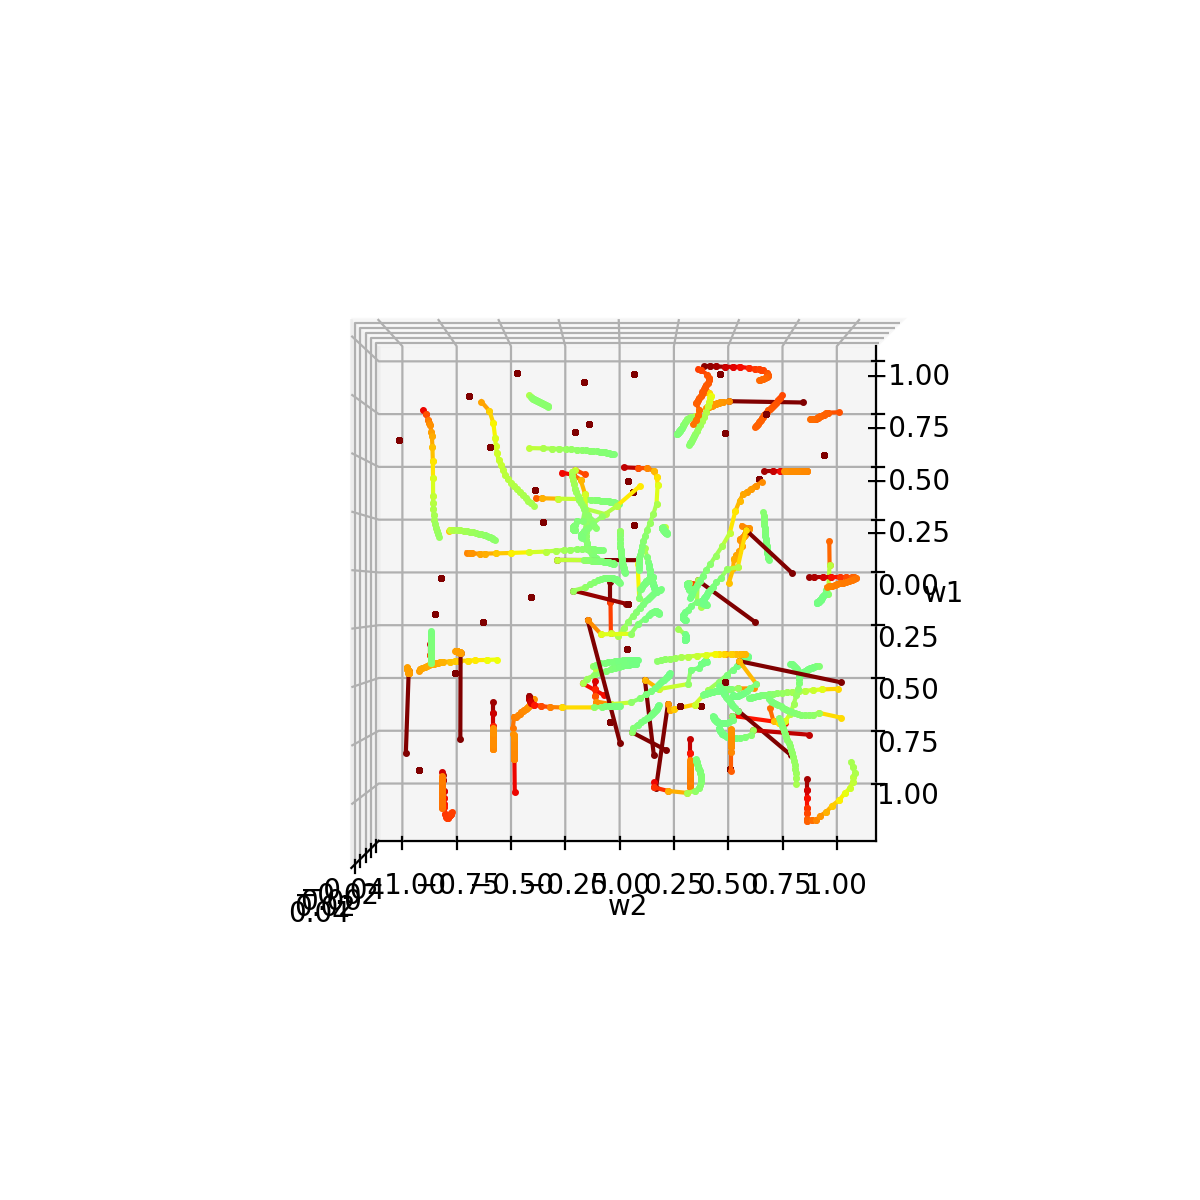

In [9]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
cmap = plt.get_cmap('jet')

for r in range(nr):
#     print ([cm(dic[r]['s'][i]/10) for i in range(ni-1)])
    ax.set_prop_cycle('color', [cmap(dic[r]['s'][i]*2) for i in range(ni-1)])
    for i in range(ni-1):
        ax.plot(dic[r]['w1'][i:i+2], dic[r]['w2'][i:i+2]
                , marker='o', markersize=1.5)

ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.view_init(elev=90., azim=0)
plt.show()

In [10]:
sess = tf.InteractiveSession()
l = 3e-1
dic = {}
nr = 1000

cmap = cm.brg  # nipy_spectral, Set1, Paired, brg
colors = cm.jet(np.linspace(0.8, 0.3, ni+1))
colors[:, 1] = np.linspace(0.5, 0.5, ni+1)
colors[:, 2] = np.linspace(0., 0.0, ni+1)

for r in range(nr):
    
    dic[r] = {}
    tf.global_variables_initializer().run()
    v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label})    
#     nng = get_norm_grad()
    dic[r]['w1'] = w[2]
    dic[r]['w2'] = w[3]
    dic[r]['b1'] = w[0]
    dic[r]['b2'] = w[1]
    dic[r]['b3'] = w[4]
    dic[r]['s'] = max(v,1e-5)
#     eigs = sorted(np.linalg.eigvals(H)[0])
#     print("Epoch {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g}, nnw {:.4g}, high_eig {:.4g}, low_eig {:.4g}."\
#             .format(i+1, get_accuracy()*100, v, nng, np.linalg.norm(w[:]), max(eigs), min(eigs) ))

sess.close() 

<IPython.core.display.Javascript object>


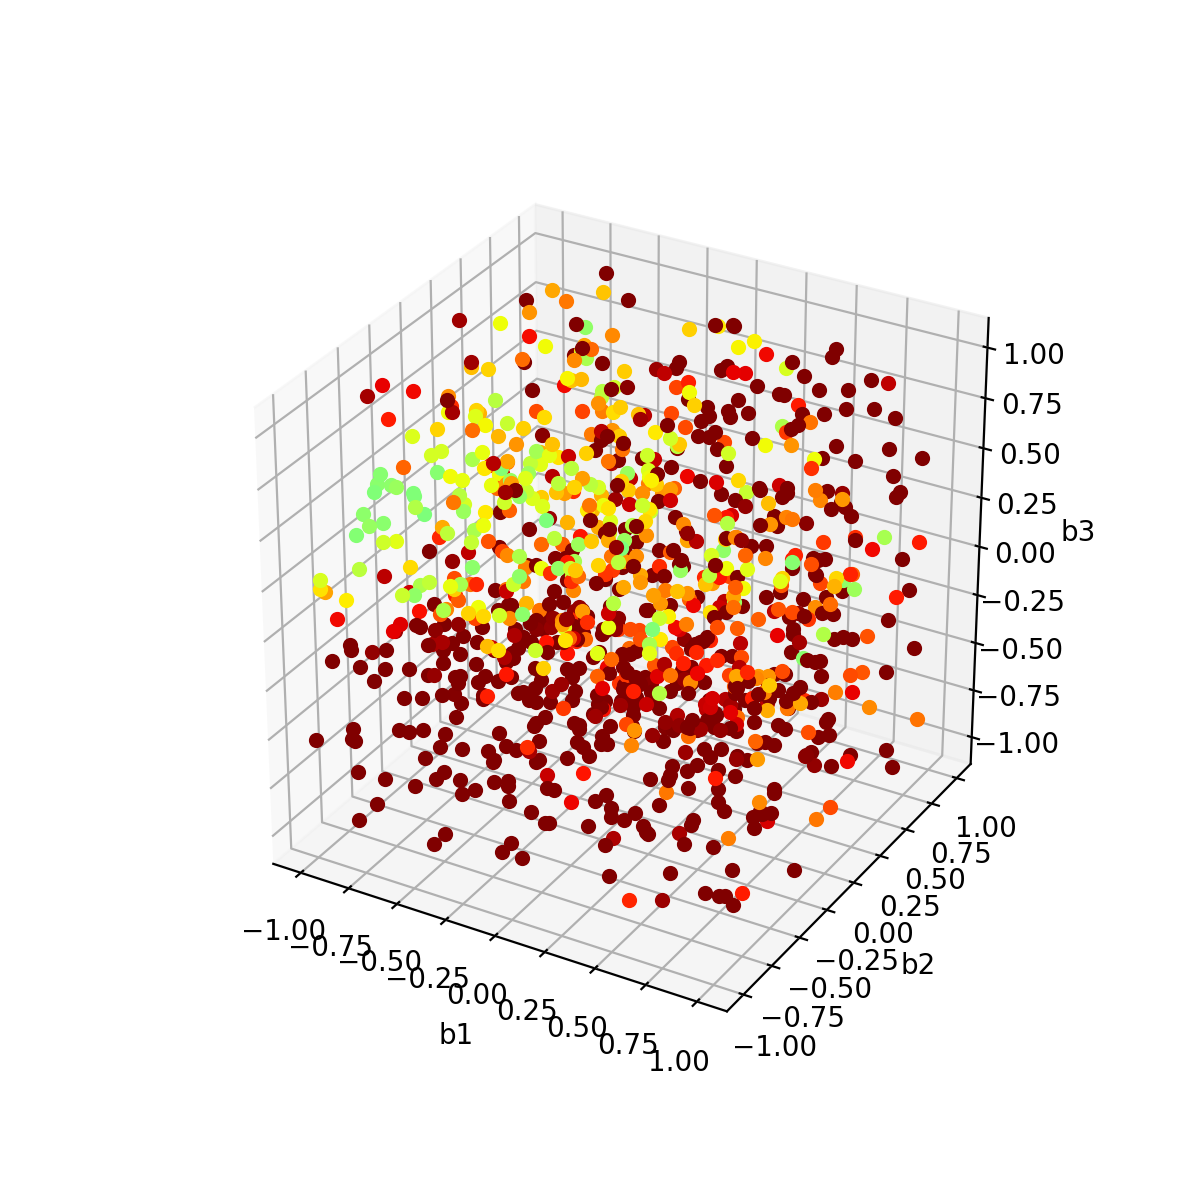

In [11]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
cmap = plt.get_cmap('jet')

for r in range(nr):
#     print ([cm(dic[r]['s'][i]/10) for i in range(ni-1)])
    ax.set_prop_cycle('color', [cmap(dic[r]['s']*2)])
    pp = ax.scatter(dic[r]['b1'], dic[r]['b2'], dic[r]['b3'])

ax.set_xlabel('b1')
ax.set_ylabel('b2')
ax.set_zlabel('b3')
plt.show()

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
cmap = plt.get_cmap('jet')

for r in range(nr):
#     print ([cm(dic[r]['s'][i]/10) for i in range(ni-1)])
    ax.set_prop_cycle('color', [cmap(dic[r]['s']*2)])
    ax.scatter(dic[r]['w1'], dic[r]['w2'])

ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.view_init(elev=90., azim=0)
plt.show()